# Second Project

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from code import data_preparation as dp
from code import visualizations as viz
import matplotlib.pyplot as plt
%matplotlib inline

## Initial Data Preparation

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Since clients seeking recommendations cannot control where there property is, increase their or their neighbor's lot sizes, or travel back in time to build their house in a different year, we will drop these and similar variables from the data, along with irrelevant columns for analysis such as ID number.

In [5]:
irrelevant = ['id', 'date', 'sqft_lot', 'waterfront', 'view', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
relevant = data.drop(columns=irrelevant)

In [6]:
relevant.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,sqft_basement,yr_renovated
0,221900.0,3,1.00,1180,1.0,Average,7 Average,1180,0.0,0.0
1,538000.0,3,2.25,2570,2.0,Average,7 Average,2170,400.0,1991.0
2,180000.0,2,1.00,770,1.0,Average,6 Low Average,770,0.0,NaN
3,604000.0,4,3.00,1960,1.0,Very Good,7 Average,1050,910.0,0.0
4,510000.0,3,2.00,1680,1.0,Average,8 Good,1680,0.0,0.0


### Dealing with Missing Values

#### *Missing Renovation Year Data*

We can see there are 3842 missing values about what year renovations we done, and a large number of zero values as well.

In [7]:
relevant['yr_renovated'].isna().sum()

3842

In [8]:
relevant['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

We will add a column indicating which values are missing and assume that NaN values are 0 values and represent no renovation. We will also bin the renovations into three categories: "not_renovated", "new_renovations", "old_renovations". We will define new renovations as ones that have been done in the past 10 years. We will then one-hot encode it so it can be used in a regression.

In [9]:
relevant['yr_ren_miss'] = dp.missing_indicator(relevant, 'yr_renovated')

In [10]:
relevant['yr_renovated'] = dp.impute_values(relevant, 'yr_renovated', type='median')

In [11]:
relevant['yr_renovated'].isna().sum()

0

In [12]:
def find_old_new(x, threshold=10):
    if x > (2020-threshold):
        return "new_ren"
    elif x == 0:
        return "not_ren"
    else:
        return "old_ren"

In [13]:
relevant['yr_renovated'] = relevant['yr_renovated'].apply(find_old_new)

In [14]:
cat, encode = dp.one_hot_encode(relevant, 'yr_renovated')

In [15]:
relevant[cat] = encode 

In [16]:
#One column dropped to avoid dummy variable trap
clean = relevant.drop(columns=['yr_renovated', 'not_ren'])

In [17]:
clean.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade,sqft_above,sqft_basement,yr_ren_miss,new_ren,old_ren
0,221900.0,3,1.00,1180,1.0,Average,7 Average,1180,0.0,False,0.0,0.0
1,538000.0,3,2.25,2570,2.0,Average,7 Average,2170,400.0,False,0.0,1.0
2,180000.0,2,1.00,770,1.0,Average,6 Low Average,770,0.0,True,0.0,0.0
3,604000.0,4,3.00,1960,1.0,Very Good,7 Average,1050,910.0,False,0.0,0.0
4,510000.0,3,2.00,1680,1.0,Average,8 Good,1680,0.0,False,0.0,0.0


As we can see we have dealt with all the NaN values.

In [18]:
clean.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
floors           0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_ren_miss      0
new_ren          0
old_ren          0
dtype: int64

### Dealing with Non-Numerical Data

In order to make a model we need to transform categorical data into numerical data. As we can see the condition, grade, and sqft_basement columns are objects, and will have to be transformed.

In [19]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   condition      21597 non-null  object 
 6   grade          21597 non-null  object 
 7   sqft_above     21597 non-null  int64  
 8   sqft_basement  21597 non-null  object 
 9   yr_ren_miss    21597 non-null  bool   
 10  new_ren        21597 non-null  float64
 11  old_ren        21597 non-null  float64
dtypes: bool(1), float64(5), int64(3), object(3)
memory usage: 1.8+ MB


#### *Dealing with Grade Column*

As we can see the grade column does include numerical ratings along with a short description of what they mean. 

In [20]:
clean['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

To begin we will just use the raw number in our model and may one-hot encode it if it optimizes the model.

In [21]:
clean['grade'] = clean['grade'].map(lambda x: int(x.split()[0]))

In [22]:
clean['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

#### *Dealing with Condition Column*

The condition column contains no interger ranks like the grade column.

In [23]:
clean['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

We could translate the ratings into a 1-5 scale, but we will just skip to one-hot encoding them.

In [24]:
cats, encode = dp.one_hot_encode(clean, 'condition')

In [25]:
labels = []
for cat in cats:
    labels.append('cond_'+cat)
labels

['cond_Average', 'cond_Fair', 'cond_Good', 'cond_Poor', 'cond_Very Good']

In [26]:
clean[labels]=encode

In [27]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['condition', 'cond_Poor'])

In [28]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21597 non-null  float64
 1   bedrooms        21597 non-null  int64  
 2   bathrooms       21597 non-null  float64
 3   sqft_living     21597 non-null  int64  
 4   floors          21597 non-null  float64
 5   grade           21597 non-null  int64  
 6   sqft_above      21597 non-null  int64  
 7   sqft_basement   21597 non-null  object 
 8   yr_ren_miss     21597 non-null  bool   
 9   new_ren         21597 non-null  float64
 10  old_ren         21597 non-null  float64
 11  cond_Average    21597 non-null  float64
 12  cond_Fair       21597 non-null  float64
 13  cond_Good       21597 non-null  float64
 14  cond_Very Good  21597 non-null  float64
dtypes: bool(1), float64(9), int64(4), object(1)
memory usage: 2.3+ MB


#### *Dealing with Sqft Basement Column*

As we can see, there are many 0 values along with some hidden missing values that were input as '?'.

In [29]:
clean['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2490.0        1
295.0         1
588.0         1
65.0          1
4820.0        1
Name: sqft_basement, Length: 304, dtype: int64

We will make a column marking the missing values and replace them with the median value.

In [30]:
clean['sqft_basement'].replace('?', np.nan, inplace=True)
clean['sqft_base_miss'] = dp.missing_indicator(clean, 'sqft_basement')

In [31]:
clean['sqft_basement'] = dp.impute_values(clean,'sqft_basement', type='median')

In [32]:
clean['sqft_basement'].value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

Lastly we will convert the boolean value of the yr_renovated_missing column to an int.

In [33]:
clean[["yr_ren_miss","sqft_base_miss"]] = clean[["yr_ren_miss","sqft_base_miss"]].astype(int)

In [34]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21597 non-null  float64
 1   bedrooms        21597 non-null  int64  
 2   bathrooms       21597 non-null  float64
 3   sqft_living     21597 non-null  int64  
 4   floors          21597 non-null  float64
 5   grade           21597 non-null  int64  
 6   sqft_above      21597 non-null  int64  
 7   sqft_basement   21597 non-null  float64
 8   yr_ren_miss     21597 non-null  int32  
 9   new_ren         21597 non-null  float64
 10  old_ren         21597 non-null  float64
 11  cond_Average    21597 non-null  float64
 12  cond_Fair       21597 non-null  float64
 13  cond_Good       21597 non-null  float64
 14  cond_Very Good  21597 non-null  float64
 15  sqft_base_miss  21597 non-null  int32  
dtypes: float64(10), int32(2), int64(4)
memory usage: 2.5 MB


In [35]:
clean.head()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,sqft_basement,yr_ren_miss,new_ren,old_ren,cond_Average,cond_Fair,cond_Good,cond_Very Good,sqft_base_miss
0,221900.0,3,1.00,1180,1.0,7,1180,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,538000.0,3,2.25,2570,2.0,7,2170,400.0,0,0.0,1.0,1.0,0.0,0.0,0.0,0
2,180000.0,2,1.00,770,1.0,6,770,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0
3,604000.0,4,3.00,1960,1.0,7,1050,910.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,510000.0,3,2.00,1680,1.0,8,1680,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0


## Making a Base Model

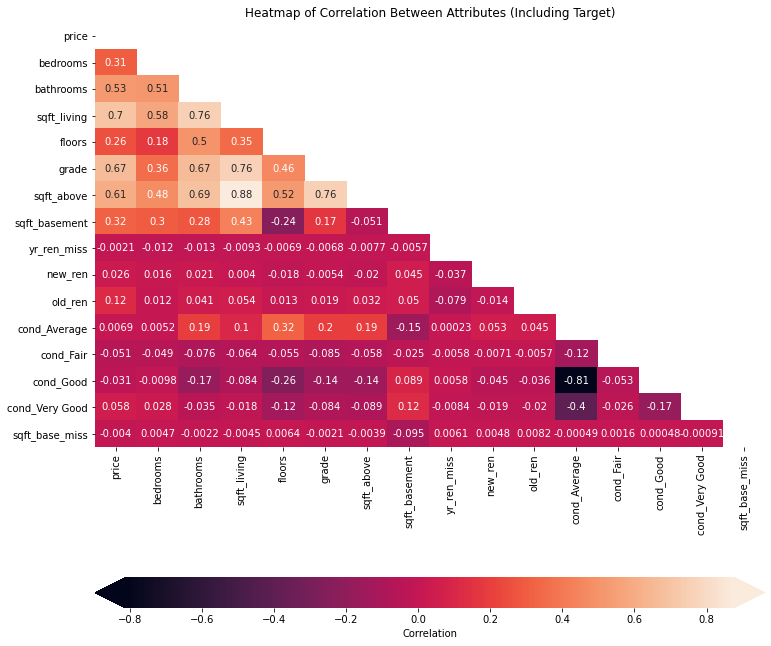

In [36]:
viz.create_heatmap(clean)

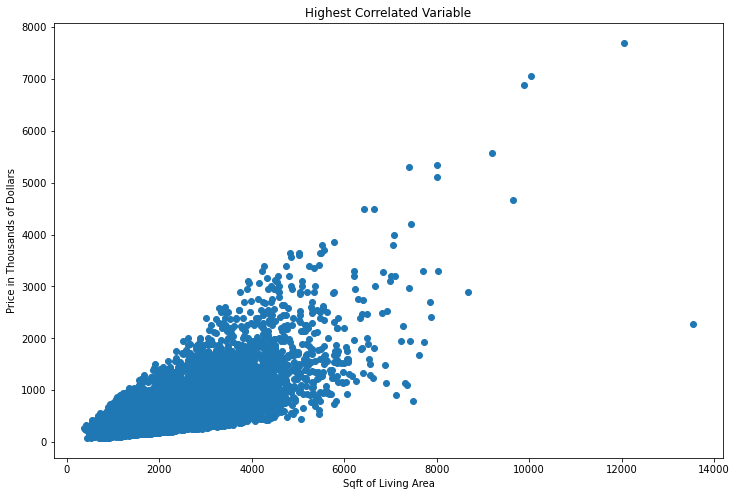

In [37]:
X_train = clean[['sqft_living']]
y_train = clean['price']
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train, y_train/1000)
plt.xlabel('Sqft of Living Area')
plt.ylabel('Price in Thousands of Dollars')
plt.title('Highest Correlated Variable');

In our initial model we will only use 'sqft_living' the variable most correlated with our target variable price. 

In [38]:
baseline_model = LinearRegression()
base_val = dp.cross_val(baseline_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.49093640472300526
Validation score: 0.4960198399390211


The squre footage of the living space only accounts for about 50% of the variance in our data, given the visualization of their relationship, we can see that the variance in price also increases with the living space, indicating the data is likely heteroskedastic, so a linear model on just this variable will be inefficient.

## Improving the Model

The first thing we can attempt to do to improve the model is add in more variables. Let's add them all in and see how the model performs.

In [39]:
X_train = clean.drop(columns='price')
y_train = clean['price']
all_model = LinearRegression()
all_val = dp.cross_val(all_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.5693464074325324
Validation score: 0.5741428262858914


As we can see, all the varibles only explain about 57% of the variance in price in our data as it stands. One potential place that we could be having issues is in the normality of the data. Let's look at a Q-Q plot to check.

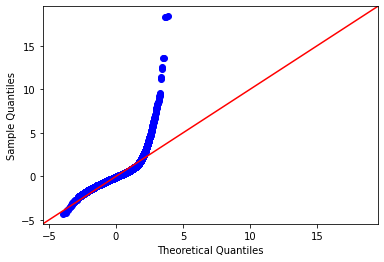

In [40]:
all_model.fit(X_train, y_train)
viz.normality_graph(all_model, X_train, y_train)

This plot indicate that our data is not very normal.

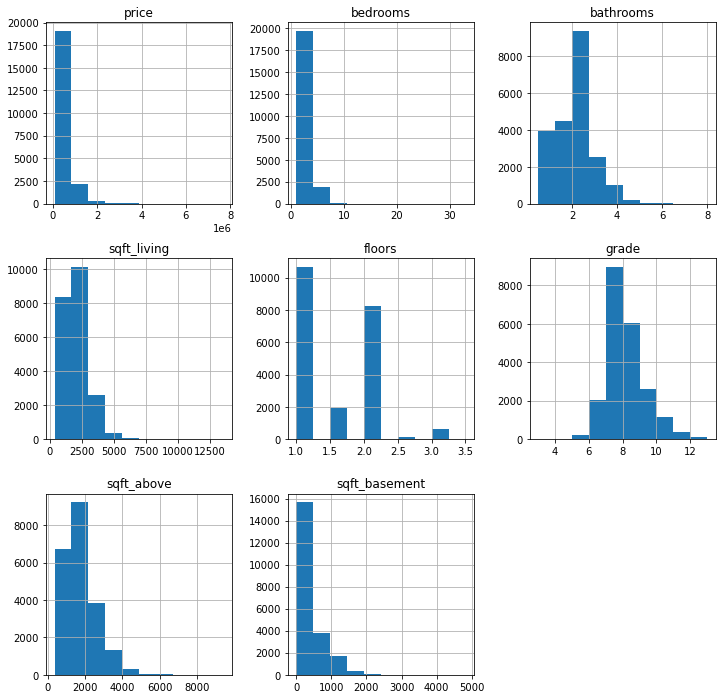

In [41]:
nonbool_columns = ['price','bedrooms','bathrooms','sqft_living','floors','grade','sqft_above','sqft_basement']
clean[nonbool_columns].hist(figsize  = [12, 12]); 

We can also see that the non-boolean columns are all skewed with lots of data cluttered around zero. We can also see that the number in the scale are also very different, with some being in the single digits and others in the thousands. We will try to deal with both these issues.

In [42]:
normalized = dp.log_normalize(clean, nonbool_columns, plus_1 = True)
bool_df = clean.drop(columns=nonbool_columns)
normalized = pd.concat([normalized, bool_df], axis =1)

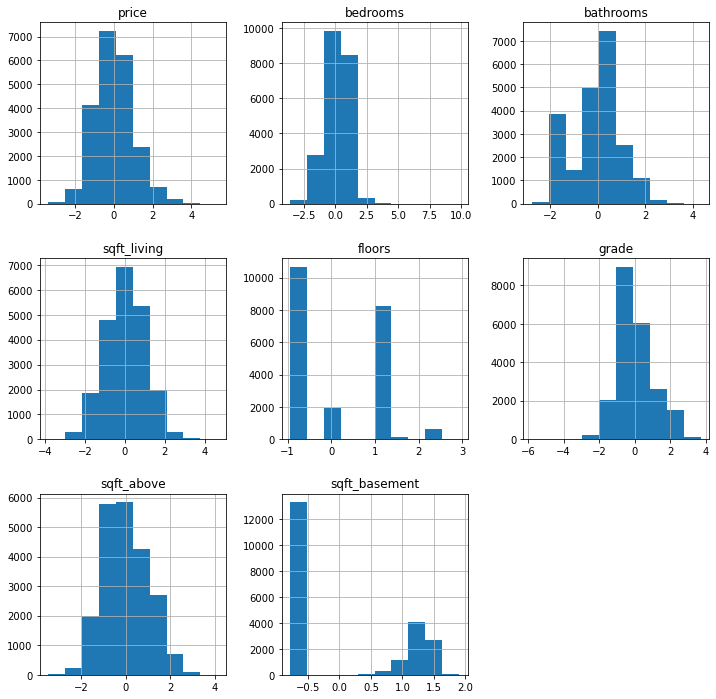

In [43]:
normalized[nonbool_columns].hist(figsize  = [12, 12]);

This is somewhat better, but sqft_basement may still be an issue. Let's construct a model using this data.

In [44]:
norm_model = LinearRegression()
X_train = normalized.drop(columns='price')
y_train = normalized['price']
normalized_model = LinearRegression()
norm_val = dp.cross_val(norm_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.5782678260184224
Validation score: 0.5833178317074601


This is a very modest improvement as it only improves the validation score by about 1% to 58%. Let's check to see if anything is off in the data.

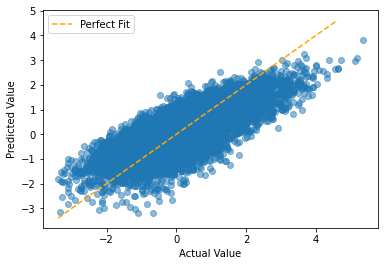

In [45]:
norm_model.fit(X_train, y_train)
viz.linearity_graph(norm_model, X_train, y_train)

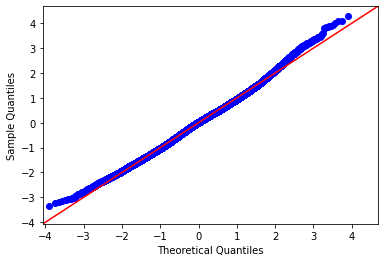

In [46]:
viz.normality_graph(norm_model, X_train, y_train)

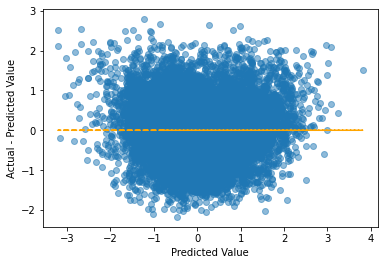

In [47]:
viz.homoscedasticity_graph(norm_model, X_train, y_train)

If there is a problem, it must be something that can't be easily seen in the visualizations. Let's get some more formal measures by using the OLS model.

In [48]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     1985.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:16:09   Log-Likelihood:                -21283.
No. Observations:               21597   AIC:                         4.260e+04
Df Residuals:                   21581   BIC:                         4.273e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1113      0.121      0.922      0.357      -0.125       0.348
bedrooms          -0.0821      0.006    -13.713      0.000      -0.094      -0.070
bathrooms         -0.0652      0.008     -8.541      0.000      -0.080      -0.050
sqft_living        0.2116      0.022      9.711      0.000       0.169       0.254
floors             0.0557      0.006      9.030      0.000       0.044       0.068
grade              0.4624      0.007     63.294      0.000       0.448       0.477
sqft_above         0.1744      0.021      8.142      0.000       0.132       0.216
sqft_basement      0.1920      0.011     18.101      0.000       0.171       0.213
yr_ren_miss        0.0300      0.012      2.591      0.010       0.007       0.053
new_ren            0.5300      0.056      9.422      0.000       0.420       0.640
old_ren            0.4644      0.027     17.295      0.000       0.412       0.517
cond_Average      -0.2168      0.121     -1.794      0.073      -0.454       0.020
cond_Fair         -0.3276      0.130     -2.513      0.012      -0.583      -0.072
cond_Good         -0.0425      0.121     -0.351      0.726      -0.280       0.195
cond_Very Good     0.2340      0.122      1.923      0.055      -0.005       0.473
sqft_base_miss     0.1441      0.032      4.517      0.000       0.082       0.207
==============================================================================
Omnibus:                      104.820   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.910
Skew:                           0.150   Prob(JB):                     1.36e-24
Kurtosis:                       3.180   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The varibles: condition good, condition average, and condition very good all have p-values over 0.05. The condition score over 30 also indicates there is strong multicollinearity in the model, but not high enough to trigger a warning from statsmodel.

In [49]:
drop_condition = normalized.drop(columns=['cond_Average','cond_Good','cond_Very Good'])

In [50]:
d_cond_model = LinearRegression()
X_train = drop_condition.drop(columns='price')
y_train = drop_condition['price']
d_cond_model = LinearRegression()
d_cond_val = dp.cross_val(norm_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.5624110985207517
Validation score: 0.5683472391981768


In [51]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     2328.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:16:09   Log-Likelihood:                -21678.
No. Observations:               21597   AIC:                         4.338e+04
Df Residuals:                   21584   BIC:                         4.349e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0208      0.005     -4.064      0.000      -0.031      -0.011
bedrooms          -0.0747      0.006    -12.275      0.000      -0.087      -0.063
bathrooms         -0.0724      0.008     -9.341      0.000      -0.088      -0.057
sqft_living        0.2645      0.022     11.960      0.000       0.221       0.308
floors             0.0322      0.006      5.209      0.000       0.020       0.044
grade              0.4460      0.007     60.204      0.000       0.432       0.461
sqft_above         0.1315      0.022      6.046      0.000       0.089       0.174
sqft_basement      0.1831      0.011     16.959      0.000       0.162       0.204
yr_ren_miss        0.0262      0.012      2.219      0.027       0.003       0.049
new_ren            0.4392      0.057      7.682      0.000       0.327       0.551
old_ren            0.4326      0.027     15.838      0.000       0.379       0.486
cond_Fair         -0.2152      0.051     -4.208      0.000      -0.315      -0.115
sqft_base_miss     0.1385      0.032      4.263      0.000       0.075       0.202
==============================================================================
Omnibus:                      108.988   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.287
Skew:                           0.167   Prob(JB):                     6.83e-25
Kurtosis:                       3.113   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Eliminating these variable solved the collinearity issue, but lowered the R-square score a bit, which is not what we would want. Let's try instead to drop the one hot encoded condition columns and replace them with a column representing condition ratings on a 1-5 scale that we will then normalize and stardardize.

In [52]:
cond_rated = drop_condition.drop(columns='cond_Fair')
cond_rated['condition'] = data['condition'].replace({'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5})
cond_rated['condition'] = dp.log_normalize(cond_rated, ['condition'], plus_1 = True)

In [53]:
cond_rated.head()

,price,bedrooms,bathrooms,sqft_living,floors,grade,sqft_above,sqft_basement,yr_ren_miss,new_ren,old_ren,sqft_base_miss,condition
0,-1.402030,-0.320358,-1.644179,-1.125590,-0.947109,-0.531776,-0.753642,-0.785207,0,0.0,0.0,0,-0.622732
1,0.279944,-0.320358,0.290982,0.709433,0.988631,-0.531776,0.672641,1.112348,0,0.0,1.0,0,-0.622732
2,-1.799470,-1.687555,-1.644179,-2.131467,-0.947109,-1.543286,-1.752625,-0.785207,1,0.0,0.0,0,-0.622732
3,0.499709,0.740121,1.118601,0.070563,-0.947109,-0.531776,-1.026843,1.372126,0,0.0,0.0,0,2.266399
4,0.178437,-0.320358,-0.028056,-0.292854,-0.947109,0.360438,0.073387,-0.785207,0,0.0,0.0,0,-0.622732


In [54]:
cond_rated_model = LinearRegression()
X_train = cond_rated.drop(columns='price')
y_train = cond_rated['price']
cond_rated_model = LinearRegression()
cond_rated_val = dp.cross_val(norm_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.5765152449351401
Validation score: 0.5812220189915808


In [55]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     2462.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:16:09   Log-Likelihood:                -21331.
No. Observations:               21597   AIC:                         4.269e+04
Df Residuals:                   21584   BIC:                         4.279e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0246      0.005     -4.893      0.000      -0.034      -0.015
bedrooms          -0.0830      0.006    -13.846      0.000      -0.095      -0.071
bathrooms         -0.0641      0.008     -8.404      0.000      -0.079      -0.049
sqft_living        0.2167      0.022      9.928      0.000       0.174       0.260
floors             0.0562      0.006      9.159      0.000       0.044       0.068
grade              0.4575      0.007     62.741      0.000       0.443       0.472
sqft_above         0.1702      0.021      7.936      0.000       0.128       0.212
sqft_basement      0.1912      0.011     17.989      0.000       0.170       0.212
yr_ren_miss        0.0292      0.012      2.519      0.012       0.006       0.052
new_ren            0.5266      0.056      9.347      0.000       0.416       0.637
old_ren            0.4633      0.027     17.221      0.000       0.411       0.516
sqft_base_miss     0.1441      0.032      4.510      0.000       0.082       0.207
condition          0.1249      0.005     26.896      0.000       0.116       0.134
==============================================================================
Omnibus:                      122.914   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.948
Skew:                           0.158   Prob(JB):                     3.67e-29
Kurtosis:                       3.212   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This brought the model back the the previous performance, but no better. Let's look at the relationship between each of our potential variables and price and see if there is some chance that the relationship is non-linear, or look for other oddities.

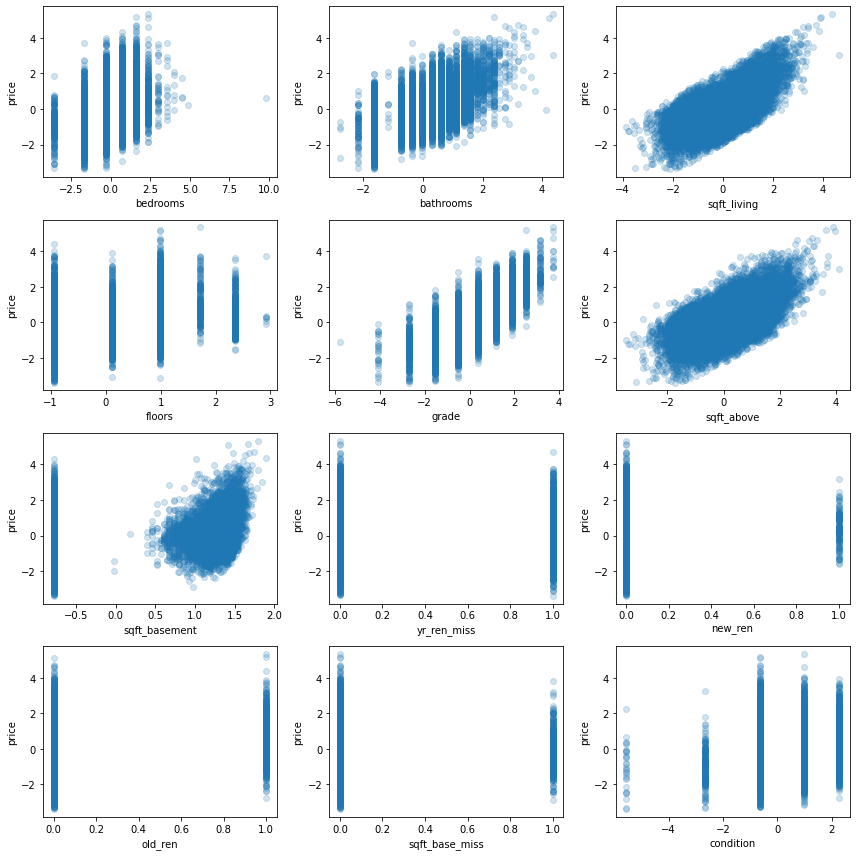

In [56]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 12))
fig.set_tight_layout(True)

for index, col in enumerate(X_train.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("price")

There is definitely something amiss it the sqft_basement data, there seems to be a weak correlation in the non-zero data, and the missing data seems to be lower in price than the zeros.

In [57]:
zero_norm = cond_rated['sqft_basement'].median()
median_sqft = cond_rated[cond_rated['sqft_basement']!=zero_norm]['sqft_basement'].median()
imputed_sqft = cond_rated
imputed_sqft['sqft_basement'].replace(zero_norm, median_sqft, inplace=True)

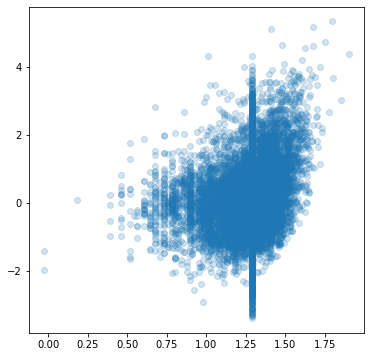

In [58]:
fig, axes = plt.subplots(figsize=(6, 6))
plt.scatter(imputed_sqft['sqft_basement'], imputed_sqft['price'], alpha=0.2);

In [59]:
imputed_sqft_model = LinearRegression()
X_train = imputed_sqft.drop(columns='price')
y_train = imputed_sqft['price']
imputed_sqft_model = LinearRegression()
imputed_sqft_val = dp.cross_val(norm_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.5711216263275507
Validation score: 0.5758843592410479


Imputing that the zero data is mostly missing, and that it is around the median, was risky assumption and it didn't improve the model, so we will just scrap this and return to the older model. The most likely explanation of the low R-square is that these factor that are in the home owners control probably don't account for all the variance in price, since location and the like probably play a huge role. 

In [60]:
final_model = LinearRegression()
X_train = cond_rated.drop(columns='price')
y_train = cond_rated['price']
final_model.fit(X_train, y_train)

LinearRegression()

## Interpreting the Model

So we have our final model, unfortunately since we standardized the scores and log normalize the data, the coeffients are not as directly interpretable.

In [61]:
coef = dict(zip(X_train.columns, final_model.coef_))

In [62]:
coef

{'bedrooms': -0.08637353357957232,
 'bathrooms': -0.05687544703570944,
 'sqft_living': 0.5661981745978046,
 'floors': 0.054805063789119104,
 'grade': 0.4660739089745443,
 'sqft_above': -0.17005968502152286,
 'sqft_basement': -0.26917155632461154,
 'yr_ren_miss': 0.02966697968204699,
 'new_ren': 0.5219708753000183,
 'old_ren': 0.47930938828891306,
 'sqft_base_miss': -0.002745406802545615,
 'condition': 0.1241550044615797}

In [63]:
predict_df = pd.DataFrame()
bed_median = X_train.groupby('bedrooms').median().reset_index()
predict_df['bedrooms'] = bed_median['bedrooms']
predict_df['price'] = final_model.predict(bed_median)
predict_df[['bedrooms', 'price']] = dp.log_denormalize(predict_df, ['bedrooms', 'price'], clean, plus_1 = True)

In [64]:
predict_df

,bedrooms,price
0,1.166879,229527.982591
1,2.013693,328544.263023
2,2.965680,358612.955882
3,4.004395,526873.417361
4,5.117900,561892.853354
5,6.297710,538051.943607
6,7.537423,544432.748123
7,8.832005,587232.027165
8,10.177369,444863.597069
9,11.570124,489066.332827


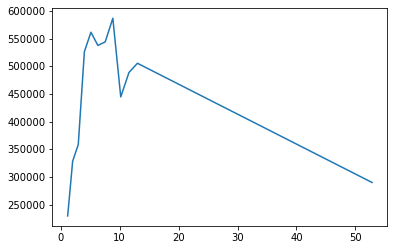

In [65]:
plt.plot(predict_df['bedrooms'],predict_df['price']);

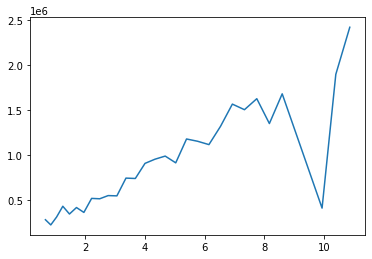

In [69]:
predict_df = dp.predict_median_effect('bathrooms', X_train, clean, final_model, target = 'price')
plt.plot(predict_df['bathrooms'],predict_df['price']);

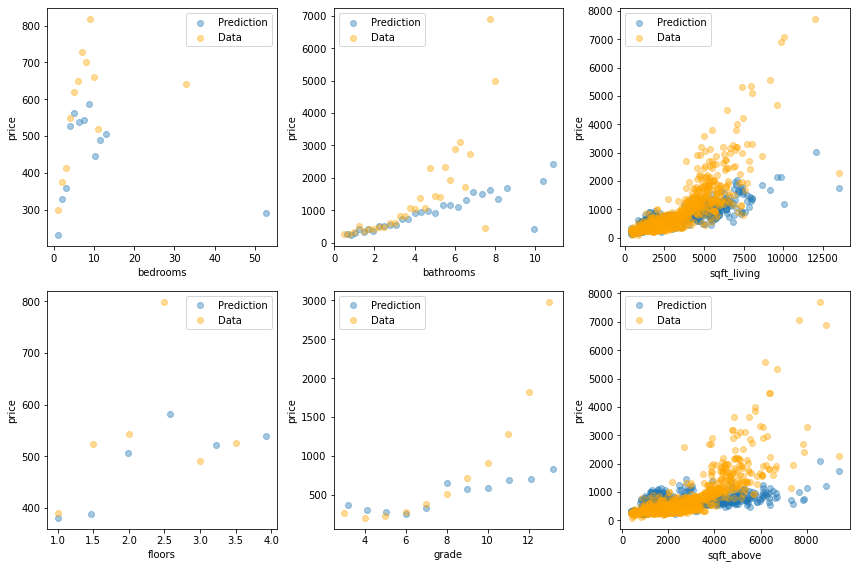

In [80]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
fig.set_tight_layout(True)
cols = ['bedrooms','bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above']

for index, col in enumerate(cols):
    predict_df = dp.predict_median_effect(col, X_train, clean, final_model, target = 'price')
    ax = axes[index//3][index%3]
    ax.scatter(predict_df[col], predict_df['price']/1000, alpha = 0.4)
    clean_med = clean.groupby(col).median().reset_index()
    ax.scatter(clean_med[col], clean_med['price']/1000, c='orange', alpha = 0.4)
    ax.set_xlabel(col)
    ax.set_ylabel("price")
    ax.legend(labels=['Prediction', 'Data'])